In [7]:
# для корректного показа презентации лучше установить RISE
# установка пакета для режима презентации

#pip install Rise

# О Себе


In [8]:
from IPython.display import Image
from IPython.core.display import HTML

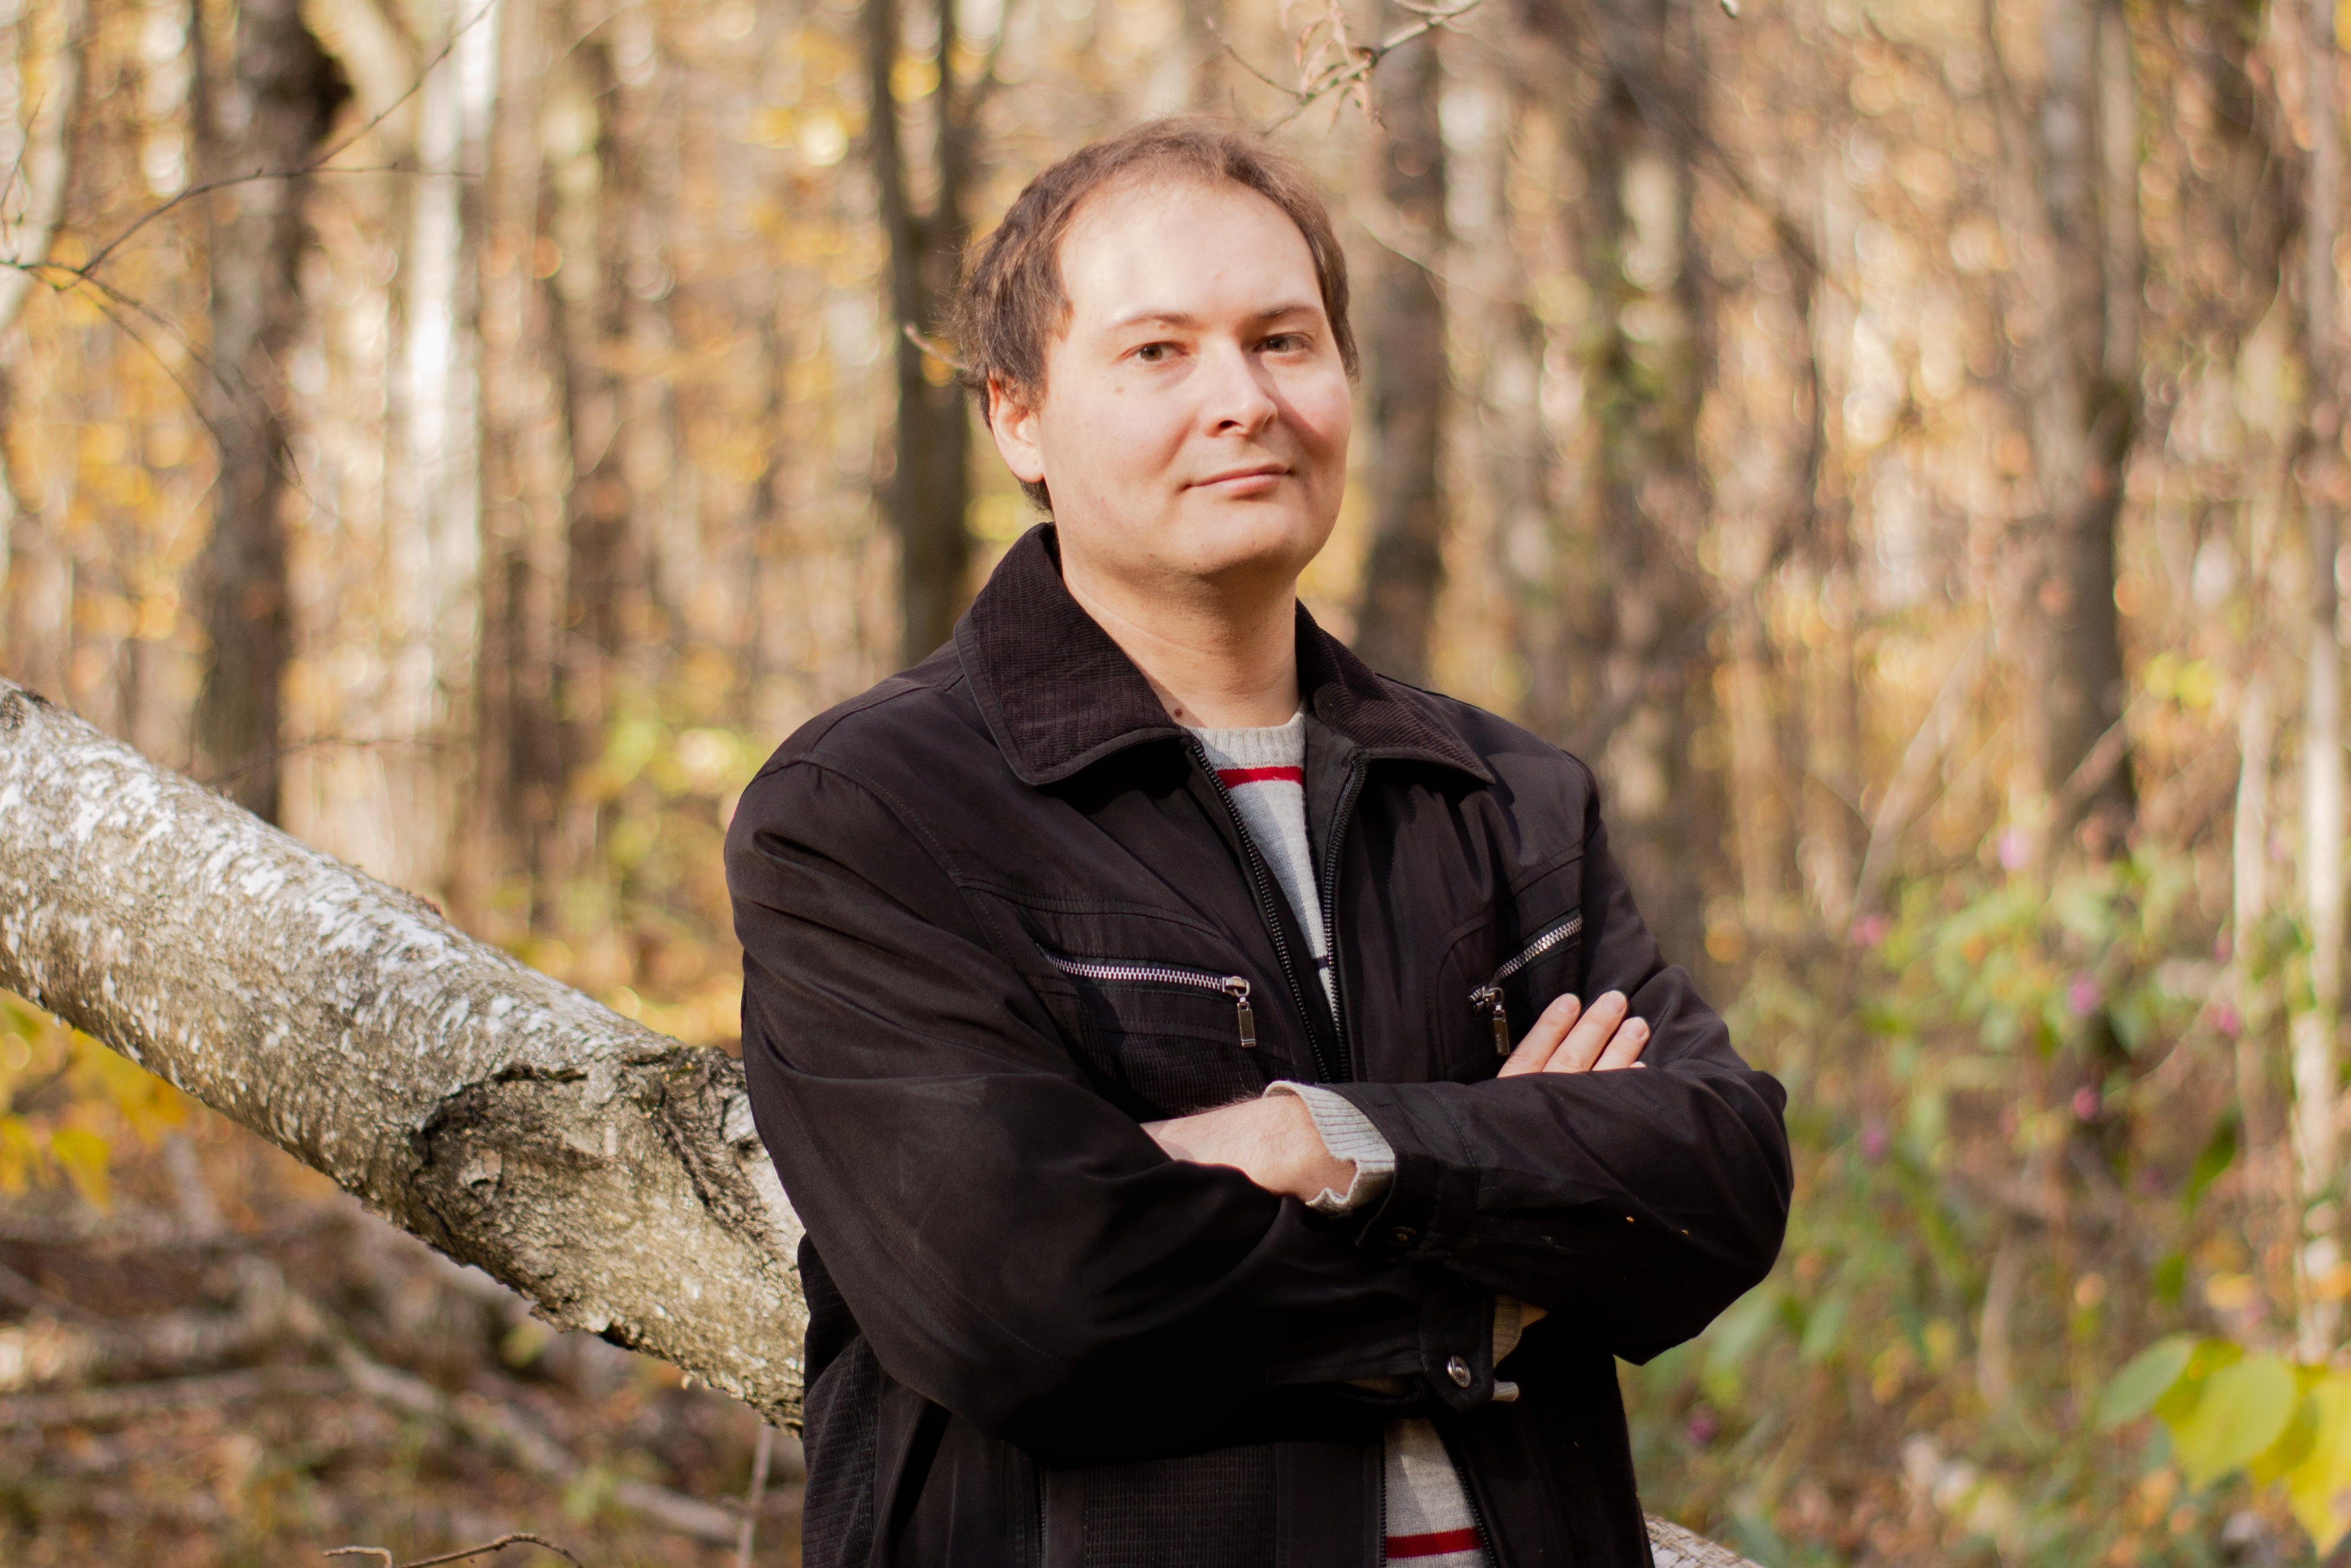

In [9]:
Image(filename = "presentation_img/My_picture.jpg", width=800, height=800)

Привет, меня  зовут Рауль Габбасов. Я научный работник в области физики наноструктур.
Представляю вам мой дипломный проект для подготовки перехода из Science в Data Science.

# Основные задачи проекта

1. Чтение датасета
2. Очистка данных
3. Генерация новых признаков
4. Разведочный анализ
5. Обучение ML-моделей и оценка их эффективности
6. Построение пайплана
7. Реализация API - сервиса на основе лучшей  модели.


# 1.0. Импорты

In [10]:
import pandas as pd
import os
import datetime as dt
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# 1.1. Файлы данных

In [ ]:
import os


In [14]:
# Считываем файл ga_hits. Нас интересуют лишь колонки 'session_id' и 'event_action'.
df_h = pd.read_csv('./data/raw data/ga_hits.csv', usecols =['session_id','event_action'])
# Размер датфрейма после чтения
df_h.shape

(15726470, 2)

In [70]:
# Подготовим список целевых действий для последующей фильтрации
event_target = ['sub_car_claim_click','sub_car_claim_submit_click', 'sub_open_dialog_click',
                'sub_custom_question_submit_click', 'sub_call_number_click','sub_callback_submit_click',
                'sub_submit_success','sub_car_request_submit_click']
# Фильтруем датасет на предмет наличия целевых действий
df_h = df_h[df_h.event_action.isin (event_target)]
# Т.к. в рамках задачи распределение по целевым действиям интереса не представляет, то заменим значения event_action на 1
df_h['event_action'] = 1
# Удалим возможные повторы
df_h = df_h.drop_duplicates()
# Размер датфрейма после фильтрации
df_h.shape

(50760, 2)

In [15]:
# Считываем файл ga_sessions.
df_s = pd.read_csv('./data/raw data/ga_sessions.csv', dtype = {'client_id': 'str'})
# Проверка на отсутствие повторов
df_s = df_s.drop_duplicates()
# Размер датфрейма после чтения
df_s.shape

FileNotFoundError: [Errno 2] No such file or directory: '.data/raw data/ga_sessions.csv'

# 2. Подготовка данных
## 2.1. Формирование единого датасета

In [72]:
# Соединяем два датафрейма. К данным о сессии (df_s)  будет приписана колонка с целевой переменной со значением 1, 
# если есть совпадения по session_id
df = df_s.merge(df_h, on = 'session_id', how='left')

In [73]:
# Оптимизация памяти: удаляем ненужные датафреймы 
del df_s,df_h

## 2.2. Подготовка целевой переменной

In [74]:
# Пропуски в целевой переменной заполняем 0. Т.к. очевидно, что в оставшихся сессиях целевого действия не произошло
df.event_action = df.event_action.fillna(value=0)
# Проверим целевую переменную на сбалансированность классов
target = df.event_action.value_counts()
target

0.0    1809728
1.0      50314
Name: event_action, dtype: int64

## 2.3. Исследование данных на пропуски

In [75]:
# Список всех признаков, в которых имеются пропущенные значения
missing_values_ratio = (df.isna().sum()/len(df)*100).sort_values(ascending=False)
missing_values_ratio = missing_values_ratio[missing_values_ratio>0]
print('Признак:       ', 'Процент пропусков:')
missing_values_ratio

Признак:        Процент пропусков:


device_model     99.121633
utm_keyword      58.174009
device_os        57.533002
device_brand     19.740307
utm_adcontent    18.043410
utm_campaign     11.806346
utm_source        0.005215
dtype: float64

In [76]:
# Признак device_model имеет почти 100 % пропусков и потому неинформативен. Удаляем.
# Признак utm_keyword заменим бинарным признаком is_keyword со значениями 0 - при наличии пропуска, иначе 1
# Признак device_os содержит больше половины пропусков и сильно коррелирует с device_brand. Удаляем.
df = df.drop(['device_model','device_os','utm_keyword'],axis=1)

In [77]:
# Остальные 4 признака  категориальные, поэтому пропуски можно заменить на 'other'
fill_list = ['utm_source', 'utm_adcontent', 'device_brand', 'utm_campaign']
for key in fill_list:
    df[key] = df[key].fillna(value='other')
    # Замена на 'other' дает лучшие метрики, чем на первую моду
    # df[key] = df[key].fillna(value=df[key].mode()[0])

## 2.3. Исследование данных на пропуски (2)

In [78]:
# Проверим количество полностью заполненных объектов и их процент из всей выборки
full_entries = len(df.dropna())
full_ratio = full_entries/len(df)*100
print (f'Количество полностью заполненных объектов: {full_entries} составляет {full_ratio} процентов из всей выборки')

Количество полностью заполненных объектов: 1860042 составляет 100.0 процентов из всей выборки


# 3. Преобразование признаков


In [79]:
# Список колонок датасета
df.columns

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'event_action'],
      dtype='object')

In [80]:
# сюда будем записывать уже ненужные колонки на удаление
columns_for_drop = ['session_id','client_id']

## 3.1. Численные признаки

### 3.1.1. Нумеризация разрешения экрана

In [81]:
# в device_screen_resolution встречаются некорректные данные типа (not_set) и 0х0. Заменим их первой модой
mod1 = df['device_screen_resolution'].mode()[0]
df['device_screen_resolution'] = df['device_screen_resolution'].replace(['(not set)', '0x0'], mod1 )

In [82]:
# Функция для вычисления разрешения экрана устройства.
# Для меньшего разброса значений возьмем логарифм от этой величины
def calculate_resolution(res):

    x = int (res.split('x')[0]) * int (res.split('x')[1])
    if x == 0:
        x = 1
    return log(x)

In [83]:
# Сделаем новый признак: количество пикселей на экране, а точнее логирифм от этой величины.
# (см. описание функции calculate_resolution). Оставим толко две цифры после запятой.
df['visit_screen_resolution'] = df['device_screen_resolution']\
                                .apply(calculate_resolution)\
                                .apply(lambda x: round(x, 1))\
                                .astype('float16')

# Колонка device_screen_resolution больше не нужна
columns_for_drop.append('device_screen_resolution')

### 3.1.2. Нумеризация времени  и даты визита

In [84]:
# Сформируем единую временную переменную
df['visit_datetime'] = pd.to_datetime(df['visit_date'] + ' ' + df['visit_time'])


In [85]:
# Выделим четыре типа типа зависимости из времени: по часам, по дням недели, дням и по месяцам.
# Для этой цели создадим три признака: 
# visit_dayofweek - день недели сессии
# visit_month - месяц сессии
# visit_day - день сессии
# visit_hour- час сессии
df['visit_dayofweek'] = df['visit_datetime'].dt.dayofweek.astype('int8')
df['visit_day'] = df['visit_datetime'].dt.day.astype('int8')
df['visit_month'] = df['visit_datetime'].dt.month.astype('int8')
df['visit_hour'] = df['visit_datetime'].dt.hour.astype('int8')

In [86]:
# Колонки visit_time и visit_date больше не нужны
columns_for_drop.append('visit_time')
columns_for_drop.append('visit_date')
columns_for_drop.append('visit_datetime')

### 3.1.3. Выявление выбросов в номере визита

In [87]:
# Описательная статистика по номеру визита
df.visit_number.describe()

count    1.860042e+06
mean     2.712804e+00
std      1.182907e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.640000e+02
Name: visit_number, dtype: float64

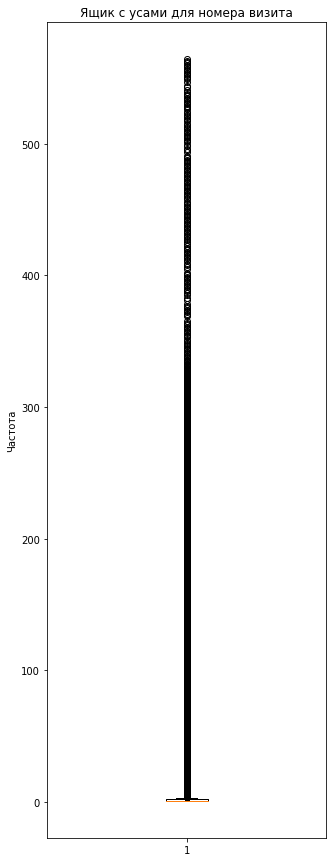

In [88]:
# Строим "ящик с усами" для номера визита
fig, ax = plt.subplots(figsize=(5,15))
ax.boxplot(df.visit_number);
ax.set_ylabel('Частота')
ax.set_title('Ящик с усами для номера визита');

In [89]:
# Нахождение границ для нормальных значений для номера визита, используя интерквартильный размах
q95 = df.visit_number.quantile(0.95)
q05 = df.visit_number.quantile(0.05)
boundaries = (q05 - 1.5*(q95-q05), q95 + 1.5*(q95-q05))
boundaries
print ('границы нормального интервала для для номера визита:', boundaries)

границы нормального интервала для для номера визита: (-6.5, 13.5)


In [90]:
# Количество выбросов для номера визита в абсолютном и относительном значении
outline_mask = (df['visit_number']<boundaries[0]) | (df['visit_number']>boundaries[1])
n_outlines = df.visit_number[outline_mask].count()
print (f'найдено {n_outlines} выбросов, что составляет около {n_outlines/len(df):.2f} от общей выборки')

найдено 40773 выбросов, что составляет около 0.02 от общей выборки


In [91]:
# Заменим строки с выбросами

df.loc[df['visit_number'] < boundaries[0], 'visit_number'] = round(boundaries[0])
df.loc[df['visit_number'] > boundaries[1], 'visit_number'] = round(boundaries[1])

## 3.2. Категориальные признаки

### 3.2.1. Объеденение городов Московского и Ленинградского регионов

В датасете много маленьких городов в Московской и Ленинградской областях. 
Объеденим их в Moscow_region и в Peterburg_region соответственно.
Город '(not set)' тоже припишем к Москве как к самому популярному значению.


In [92]:

# Создадим список городов Московской области
moscow_region = ('Aprelevka', 'Balashikha', 'Beloozyorskiy', 'Chekhov', 'Chernogolovka', 'Dedovsk', 
                 'Dmitrov', 'Dolgoprudny', 'Domodedovo', 'Dubna', 'Dzerzhinsky','Elektrogorsk', 'Elektrostal', 
                 'Elektrougli', 'Fryazino', 'Golitsyno', 'Istra', 'Ivanteyevka', 'Izhevsk', 'Kashira', 'Khimki', 
                 'Khotkovo', 'Klin', 'Kolomna', 'Korolyov', 'Kotelniki', 'Krasnoarmeysk', 'Krasnogorsk', 
                 'Krasnoznamensk', 'Kubinka', 'Kurovskoye', 'Likino-Dulyovo', 'Lobnya', 'Losino-Petrovsky', 
                 'Lukhovitsy', 'Lytkarino', 'Lyubertsy', 'Mozhaysk', 'Mytishchi', 'Naro-Fominsk', 'Nakhabino', 
                 'Noginsk', 'Odintsovo', 'Orekhovo-Zuyevo', 'Pavlovsky Posad', 'Podolsk', 'Protvino', 'Pushchino', 
                 'Pushkino', 'Ramenskoye', 'Reutov', 'Ruza', 'Sergiyev Posad', 'Serpukhov', 'Solnechnogorsk', 
                 'Staraya Kupavna', 'Stupino', 'Shchyolkovo', 'Shatura', 'Vidnoye', 'Volokolamsk', 'Voskresensk', 
                 'Yakhroma', 'Zheleznodorozhny', 'Zhukovskiy', 'Zvenigorod', 'Moscow'
                )
# И Ленинградской области
petersburg_region =('Boksitogorsk', 'Volosovo', 'Volkhov', 'Vsevolozhsk', 'Vyborg', 'Vysotsk', 'Gatchina', 
                  'Ivangorod', 'Kamennogorsk', 'Kingisepp', 'Kirishi', 'Kirovsk', 'Communar', 'Kudrovo', 
                  'Lodeynoye Pole', 'Luban', 'Murino', 'Nikolskoye', 'Novaya Ladoga', 'Otradnoe', 'Pikalevo',
                  'Podporozhie', 'Primorsk', 'Priozersk', 'Svetogorsk', 'Sertolovo', 
                  'Slantsy', 'Sosnovy Bor', 'Syasstroy', 'Tikhvin', 'Tosno', 'Shlisselburg', 'Petersburg'
                   )

In [93]:
# Объеденим города Московского и Ленинградского регионов
df['geo_city'] = df['geo_city'].replace(moscow_region, 'Moscow_region')
df['geo_city'] = df['geo_city'].replace(petersburg_region, 'Petersburg_region')

df['geo_city']  = df['geo_city'].replace(['(not set)'], 'Moscow_region' )

### 3.2.2. Создание бинарных переменных на основе категорий

In [94]:
# Создаим переменную is_Russia, указывающую из Россиии пользователь или нет
df['is_Russia'] = df['geo_country'].apply(lambda x: 1 if x in x == 'Russia' else 0)\
                                   .astype('int8')

# geo_country больше не нужен
columns_for_drop.append('geo_country')

In [95]:
# В device_category только 3 уникальных значения, поэтому целесообразнее заменить его бинарным признаком.
device_type_values = df['device_category'].value_counts(normalize = True)
device_type_values

mobile     0.792923
desktop    0.197234
tablet     0.009843
Name: device_category, dtype: float64

In [96]:
# Остается вопрос, куда отнести планшеты (tablet).
# Хотя формально это мобильное устройство, лучше убедиться в этом, посмотерв средние значение event_action по типам устройств.
# Сделаем это с помощью TargetEncoder 
target_enc = TargetEncoder(cols='device_category', smoothing = 0.5, min_samples_leaf=2)
device_type_conversion = target_enc.fit_transform(df['device_category'],df['event_action']).value_counts(normalize = True)

dict(zip(device_type_values.index,device_type_conversion.index))

{'mobile': (0.02602193683379767,),
 'desktop': (0.03138228712080531,),
 'tablet': (0.023050032772558446,)}

Как видно, планшеты ближе к мобильным устройствам. 

In [97]:
# Признак is_mobile: 1 если планшет или смартфон, иначе(т.е. ПК) 0
df['is_mobile'] = df['device_category'].apply (lambda x: 1 if x in ['mobile', 'tablet'] else 0).astype('int8')

In [98]:
# device_category больше не нужен
columns_for_drop.append('device_category')

In [99]:
# Удалим ненужные признаки 
df = df.drop(columns_for_drop,axis=1)
columns_for_drop

['session_id',
 'client_id',
 'device_screen_resolution',
 'visit_time',
 'visit_date',
 'visit_datetime',
 'geo_country',
 'device_category']

### 3.3. Текстовое описание полученных признаков

In [100]:
# Оформим текстовое описание признаков в виде словаря
feauture_description_dict = {
'event_action': 'Целевая переменная, имеющая значение 1 при совершения целевого дествия и 0 - при его отсутствии',
'visit_number': 'порядковый номер визита пользователя',
'visit_screen_resolution':'логарифм от количества пикселей на экране устройства' ,
'visit_hour':'час визита(сессии)',
'visit_dayofweek':'день недели визита',
'visit_day': 'день  визита',
'visit_month':'месяц визита',
'is_Russia' : 'рус/нерус',
'is_mobile' : 'тип устройства',
'is_keyword' : 'ключевое слово',    
'utm_campaign':'рекламная компания',
'utm_medium' : 'тип траффика',
'utm_source' : 'источник траффика',
'utm_adcontent' : 'метка рекламы',
'device_category':'тип устройства',
'device_browser':'браузер, используемый на устройстве',
'device_brand' : 'марка устройства',
'geo_city':'город'
}

for feauture,description in feauture_description_dict.items():
    print(f'{feauture} : {description}')

event_action : Целевая переменная, имеющая значение 1 при совершения целевого дествия и 0 - при его отсутствии
visit_number : порядковый номер визита пользователя
visit_screen_resolution : логарифм от количества пикселей на экране устройства
visit_hour : час визита(сессии)
visit_dayofweek : день недели визита
visit_day : день  визита
visit_month : месяц визита
is_Russia : рус/нерус
is_mobile : тип устройства
is_keyword : ключевое слово
utm_campaign : рекламная компания
utm_medium : тип траффика
utm_source : источник траффика
utm_adcontent : метка рекламы
device_category : тип устройства
device_browser : браузер, используемый на устройстве
device_brand : марка устройства
geo_city : город


## 3.4. Разведочный анализ данных

### 3.4.1. Исследование целевой переменной на сбалансированность классов

In [101]:
# Проверим целевую переменную на сбалансированность классов
target = df.event_action.value_counts()
target

0.0    1809728
1.0      50314
Name: event_action, dtype: int64

In [102]:
alpha = target[1] / target[0]
print(f'Классы целевой переменной несбалансированы.',
      f'Отношение количества "1" и "0" к друг другу в целевой переменной составляет{alpha : 0.4f}'
     )

Классы целевой переменной несбалансированы. Отношение количества "1" и "0" к друг другу в целевой переменной составляет 0.0278


Из-за сильной расбалансировки классов для более наглядной зависимости целевой переменной 
при построении гистограмм вводится нормировочный коэффициэнт alpha ~ 0.0275 для данных с event_action == 0.
В этом случае равенство высоты столбцов с "1" и "0" будет означать, что при данных параметрах конверсия в целевое действие 
принимает среднее значение по датасету. 
В случае превышения "1" над "0" - имеет место конверсия выше средней по датасету, в обратном случае - конверсия ниже средней.

### 3.4.2. Исследование зависимости целевой переменной от численных признаков

In [103]:
# Объявим функции,неообходимые для работы с признаками

# Cоздание списка бинарных признаков 
def get_binary (X):
    bins = []
    for col in X.columns:
        if df[col].nunique() == 2:
            bins.append(col)
    return bins


# Создание списка численных признаков (без учета целевой переменной).
# Для удобства сюда будут входить и бинрные признаки
def get_numerical(X, y = 'event_action'):
    nums = []
    for col in X.columns:
        if is_numeric_dtype(X[col]) and col != y :
            nums.append(col)
    return nums


# Создание списка категориальных признаков
def get_categorical(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    return cats

#numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
#categorical_features = X.select_dtypes(include=['object']).columns


In [104]:
# Зададим список численных переменных
numerical_list  = get_numerical(df,'event_action')
numerical_list 
#numerical_list = ['visit_number','visit_dayofweek', 'visit_day', 'visit_month', 'visit_hour']

['visit_number',
 'visit_screen_resolution',
 'visit_dayofweek',
 'visit_day',
 'visit_month',
 'visit_hour',
 'is_Russia',
 'is_mobile']

In [105]:
# Делим датасет по классам целевой перепенной : 1 и 0
df1 = df[df['event_action'] == 1.0]
df0 = df[df['event_action'] == 0.0]

# Для более наглядной зависимости округлим 'visit_screen_resolution' до первого знака после запятой
df1['visit_screen_resolution'] = df1['visit_screen_resolution'].apply(lambda x: round(x, 1))
df0['visit_screen_resolution'] = df0['visit_screen_resolution'].apply(lambda x: round(x, 1))
                                                                      

C:\Users\GP62\AppData\Local\Temp/ipykernel_9972/1159617628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['visit_screen_resolution'] = df1['visit_screen_resolution'].apply(lambda x: round(x, 1))
C:\Users\GP62\AppData\Local\Temp/ipykernel_9972/1159617628.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['visit_screen_resolution'] = df0['visit_screen_resolution'].apply(lambda x: round(x, 1))


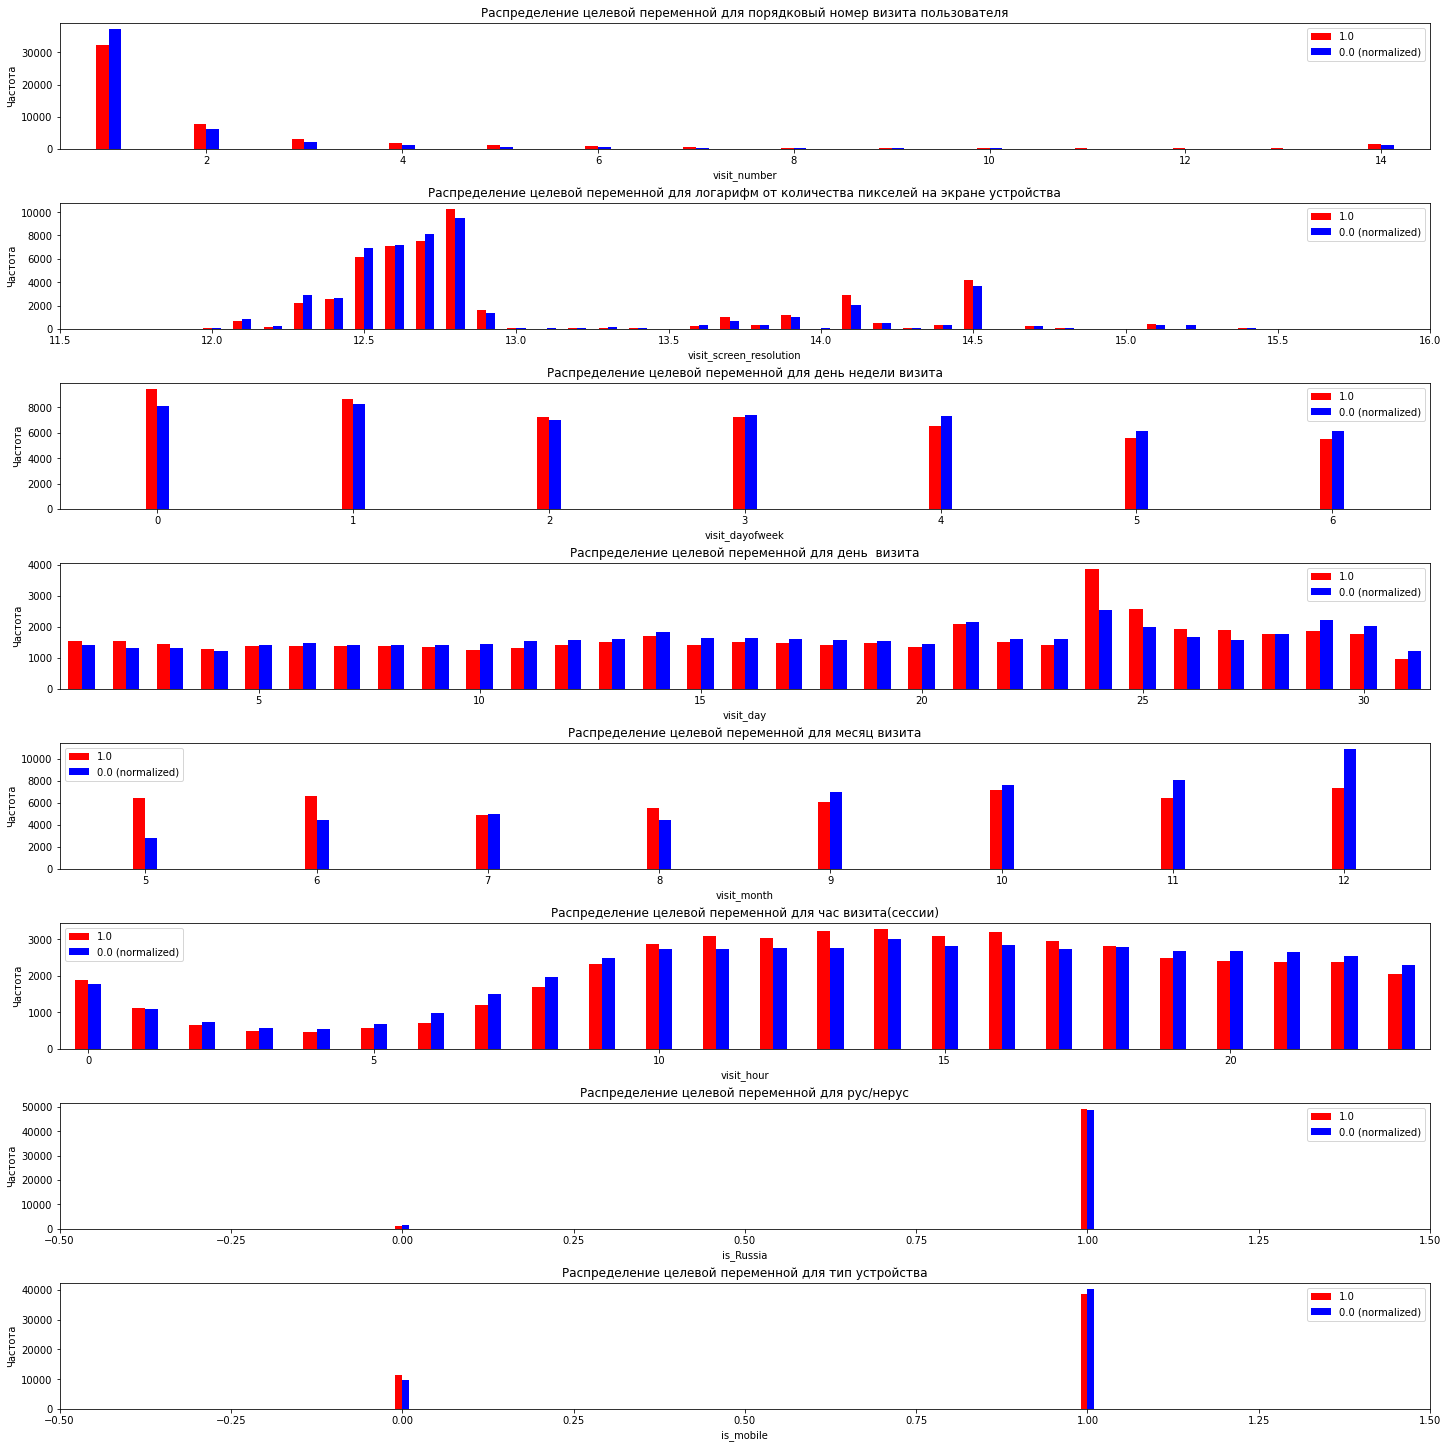

In [106]:
fig = plt.figure(figsize = (20,20), layout='constrained')
# Параметр, задающий ширину столбца гистограммы
bw = 0.3
# Определим количество гистограмм 
l = len (numerical_list)

for c,var in enumerate(numerical_list):
    # группировка классов целевой переменной по рассмаптриваемому признаку
    d1 = df1.groupby(var, as_index = False).agg({'event_action':'count'},)
    d0 = df0.groupby(var, as_index = False).agg({'event_action':'count'})
    
    # адрес ячейки где будут сторится гистограммы
    plt.subplot(l, 1, c+1)
    
    # для 'visit_screen_resolution' нужна корректировка параметров, т.к. переменная  нецелая
    if var == 'visit_screen_resolution':
        bw = 0.03
        plt.xlim([11.5, 16])
    else :
        bw = 0.01*(df0[var].max()-df0[var].min())
        plt.xlim([df0[var].min()-0.5, df0[var].max()+0.5])
    
    plt.title(f'Распределение целевой переменной для {feauture_description_dict[var]}', fontsize=12)
    plt.bar(d1[var]-bw/2, d1['event_action'], bw, color='r')
    plt.bar(d0[var]+bw/2, d0['event_action']*alpha, bw, color='b')
    plt.xlabel(var)
    plt.ylabel('Частота')
    plt.legend(['1.0', '0.0 (normalized)'],fontsize=10)
    

   


                            Основные выводы по графикам:
(Здесь и далее: успешной сессия будет считаться при совершении целевого действия, т.е. event_action == 1
в противном случае сессия неуспешная , т.е. event_action == 0)

1. Большая часть пользователей совершает только один визит. Но при этом конверсия ниже средней. С другой строны с ростом номера визита растет доля успешных сессий. 

2. Максимум (как всех, так и успешных ) сессий наблюдается в области разрешения экрана, соответствующий мобильным устройствам.
Однако, вероятно, часть пользователей перезаходит с более широкоэкранных устройств для окончательного решения. Для более детального анализа построим тепловую карту.

3. Наблюдается небольшое увеличение доли успешных сеесий в начале недели.  Минимум же наблюдается  в 5 и 6 днях (суббота, воскресенье)

4. В распределениях по дням месяца в целом наблюдается равномерное распределение удачных и неудачных сессий по числам. Однако есть и заметный максимум на 24 числе. Для более детального анализа необходимы тепловые карты.

5. С увеличением месяца наблюдается заметный рост числа посещений, но , к сожалению, количество успешных сессий от месяца к месяцу особо не меняется и находится приблизительно на одном уровне. С другой стороны количество неуспешных сессий растет, т.е. имеет место падение конверсии со временем, а значит сервис становится менее эффективным.

6. Абсолютный и относительный максимум успешных сессий - в середине дня (12-15 часов). Абсолютный и относительный минимум расположен в глубокой ночи (2-5 часов). Картину максимума/ минимума могут смазывать заказы, сделанные в других часовых поясах.

7. Средняя конверсия от внутрироссийских пользователей несколько больше, чем от зарубежных.

8. Средняя конверсия на мобильных устройствах лучше, чем на ПК.

### 3.4.4. Исследование распределений категориальных признаков

In [107]:
# Вызовем список категориальных признаков
categories_list = get_categorical(df)
categories_list

['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'device_brand',
 'device_browser',
 'geo_city']

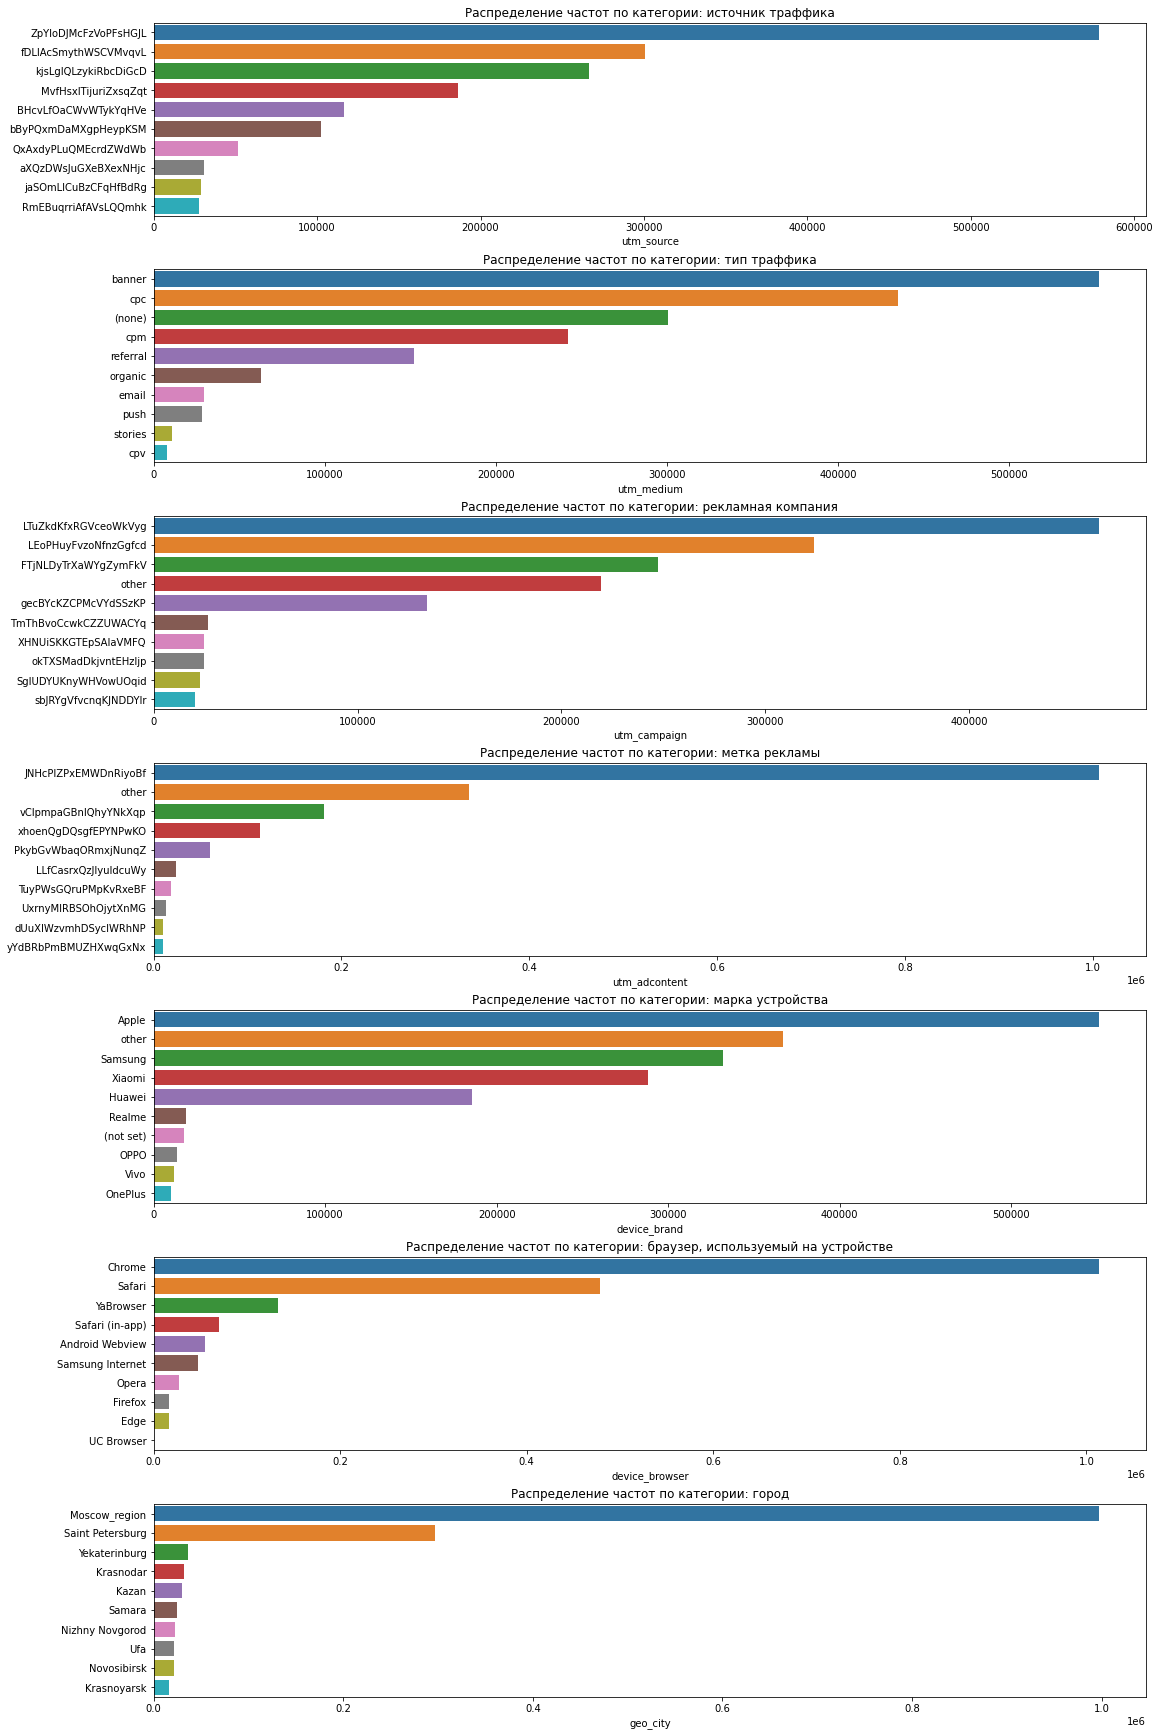

In [108]:
fig = plt.figure(figsize = (16,24), layout='constrained')
# Определим количество гистограмм 
l = len(categories_list)
# Параметр для адреса ячейки гистограммы
c=1

for (category_name, category_data) in df[categories_list].iteritems():
    plt.subplot(l, 1, c)
    title = f'Распределение частот по категории: {feauture_description_dict[category_name]}'
    # Для наглядности будем строить топ - 10 значений в каждой категории по распространенности
    sns.barplot(y=category_data.value_counts()[0:10].index, 
                x=category_data.value_counts()[0:10],
                orient = 'h'             
               ).set_title(title,fontsize=12)
    c+=1

                             Основные выводы по графикам:
 В целом, во всех категориях наблюдается четкий максимум. При этом, во всех случаях первые 3-4 верхних по частотности значения категорий статистически доминируют над остальными значениями. 

### 3.4.5. Исследование корреляций между параметрами c помощью тепловых карт

In [109]:
# Оформим построение тепловой карты в виде функции, приниамющей датафрейм и названия колонок
def heat_xy(df,x,y):
    fig = plt.figure(figsize = (12,12), layout='constrained')
    hm = pd.pivot_table(df, index= x,columns= y, values='event_action', aggfunc= conversion)
    title = f'Тепловая карта корреляции {feauture_description_dict[x]} / {feauture_description_dict[y]}'
    sns.heatmap(hm, cmap="coolwarm")

<AxesSubplot:>

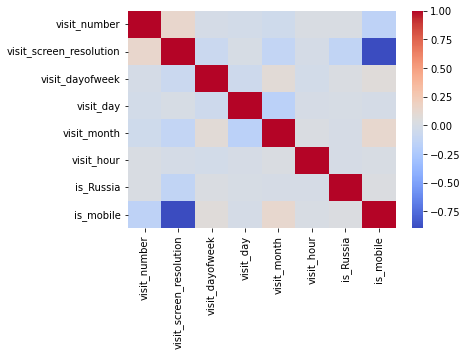

In [110]:
# Исследуем корреляцию численных признаков между собой
sns.heatmap(df[numerical_list].corr(), cmap="coolwarm")

In [111]:
# Наблюдается сильная корреляция между парами (is_keyword, visit_month)  (is_mobile, visit_screen_resolution).
# Построим тепловые карты для пар этих признаков

In [112]:
conversion =  lambda x: np.sum(x)/len(x)

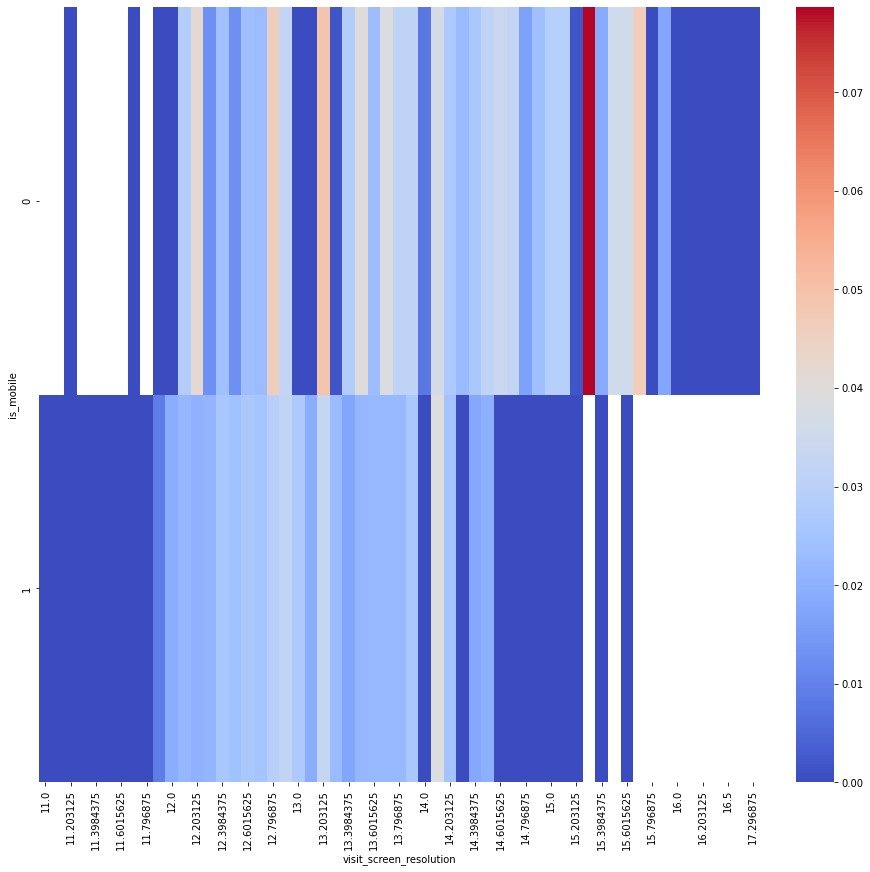

In [113]:
x = 'is_mobile'
y = 'visit_screen_resolution'
heat_xy(df,x,y)

Выводы по графику:
 Область между нижней границей для ПК устройств и  верхней границей для мобильных устройств значительна и в нее попадает большое количество событий. Следовательно, число пикселей  плохо отражает тип устройства и от него лучше избавится.

In [114]:
#Удалим ненужные признаки
df = df.drop(['visit_screen_resolution'], axis=1)

<AxesSubplot:>

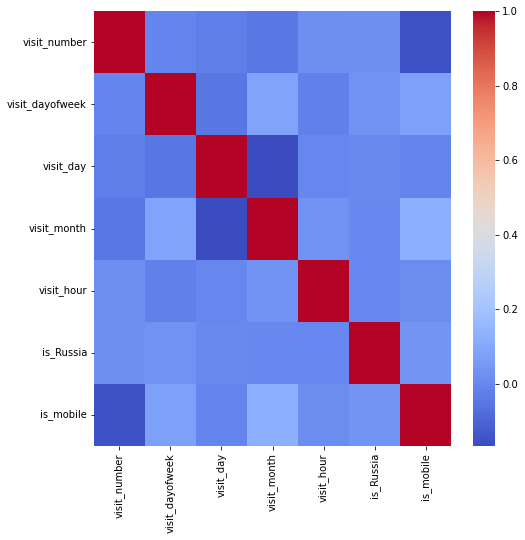

In [115]:
# Создадим карту корреляций численных признаков между собой
numerical_list  = get_numerical(df,'event_action')
fig, ax = plt.subplots(figsize=(8,8))  
sns.heatmap(df[numerical_list].corr(), cmap="coolwarm",ax=ax)


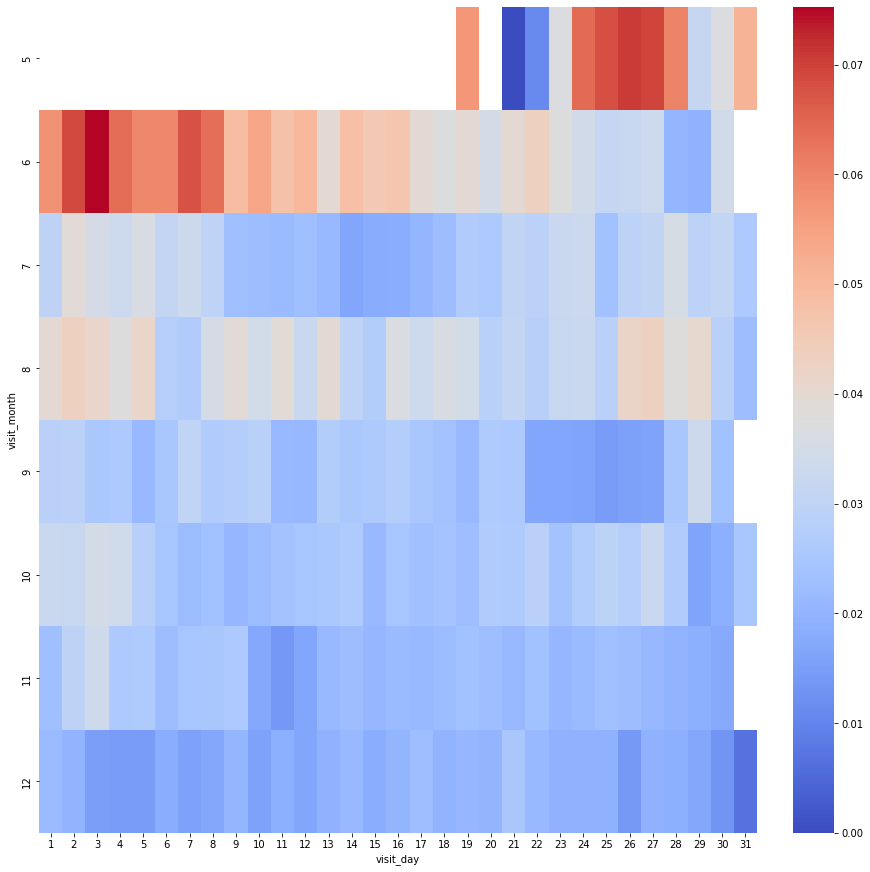

In [116]:
# Изучим календарную зависимость конверсии
x = 'visit_month'
y = 'visit_day'
heat_xy(df,x,y)

 Выводы по графику:
 Май и начало июня являются наиболее успешными для сервиса. В декабре конверсия наоборот минимальна.

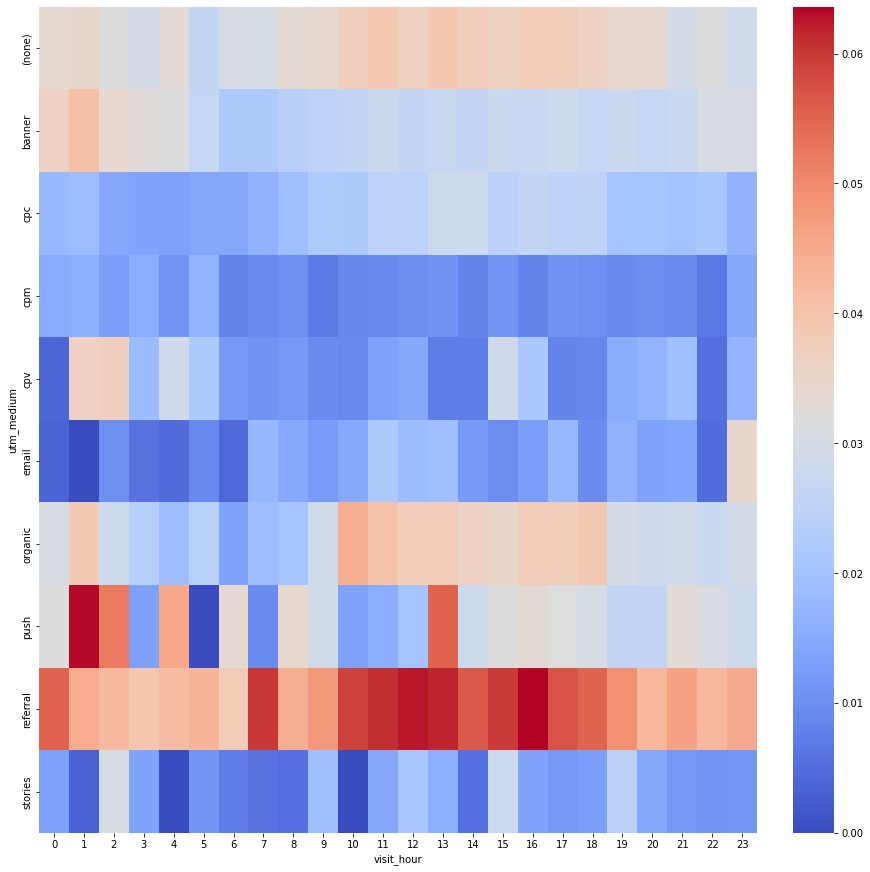

In [117]:
# Изучим корреляцию типа трафиика часом входа
x = 'utm_medium'
y = 'visit_hour'
top_10_list= df[x].value_counts()[0:10].index
heat_xy(df[df[x].isin(top_10_list)],x,y)

Выводы по графику:
Наибольшая конверсия достигается при переходе по ссылке в рабочее (12-16 часов) время

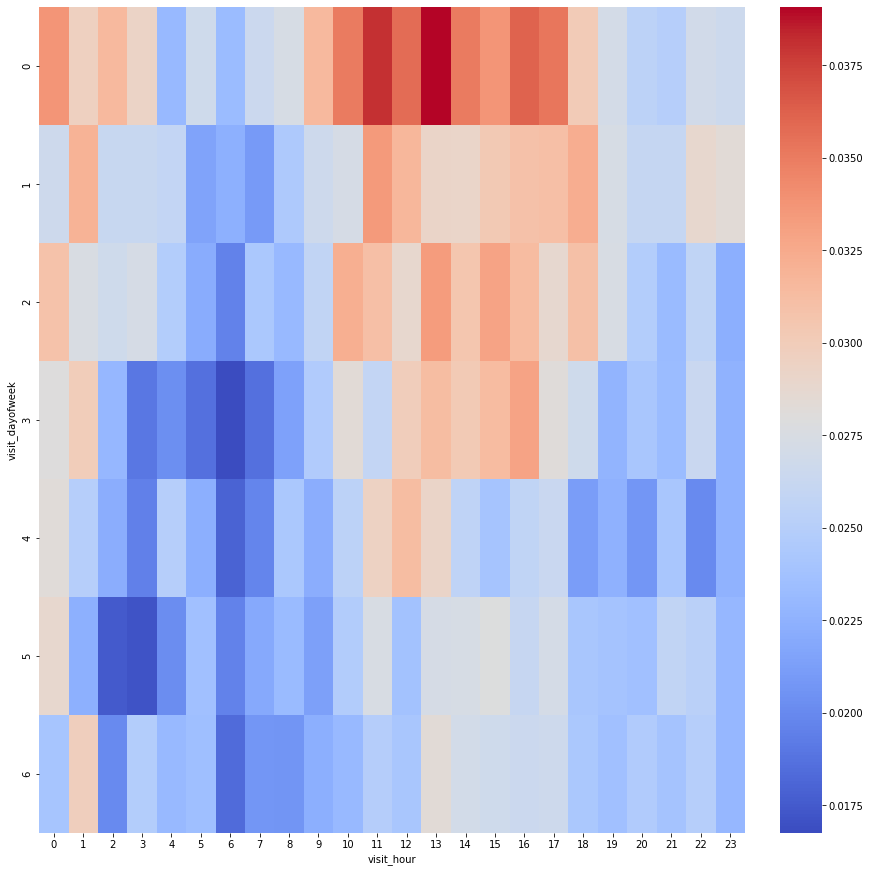

In [118]:
# Рассмотрим эффективность конверсии в разрезе день недели/час
y = 'visit_hour'
x = 'visit_dayofweek'
heat_xy(df,x,y)

                            Выводы по графикам:
Максимальная конверсия внаблюдается в начале недели и середине дня. Также есть менее заметные пики около полуночи, более интенсивные в начале недели и менее - в конце.


## 3.5. Стандартизация  численных переменных 


In [119]:
# Вызовем список численнных признаков
numerical_list = get_numerical(df,'event_action')
binary_list = get_binary(df)
# Будем скалировать только численные небинарные признаки
scale_list = [x for x in numerical_list if x not in binary_list]
scale_list

['visit_number', 'visit_dayofweek', 'visit_day', 'visit_month', 'visit_hour']

In [120]:
# Стандартизуем численные признаки
std_scaler = StandardScaler()
std_scaler.fit(df[scale_list])
df[scale_list] = std_scaler.transform(df[scale_list]).astype('float16')

## 3.6. Target encoding

Проведем Target_encoding (как альтернативу One Hot Encoding): замена категориального значения средним 
значением целевой переменной по этой категории

In [121]:
categories_list = get_categorical(df)
categories_list

['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'device_brand',
 'device_browser',
 'geo_city']

In [122]:
target_enc = TargetEncoder(cols=categories_list, smoothing = 0.5, min_samples_leaf=2)
df[categories_list] = target_enc.fit_transform(df[categories_list],df['event_action']).astype('float16')

# 3.7. Подитог

In [123]:
# Выведем общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860042 entries, 0 to 1860041
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   visit_number     float16
 1   utm_source       float16
 2   utm_medium       float16
 3   utm_campaign     float16
 4   utm_adcontent    float16
 5   device_brand     float16
 6   device_browser   float16
 7   geo_city         float16
 8   event_action     float64
 9   visit_dayofweek  float16
 10  visit_day        float16
 11  visit_month      float16
 12  visit_hour       float16
 13  is_Russia        int8   
 14  is_mobile        int8   
dtypes: float16(12), float64(1), int8(2)
memory usage: 74.5 MB


In [124]:
# Обновим текстовое описание признаков в виде словаря
feauture_description_dict = {
'event_action': 'Целевая переменная, имеющая значение 1 при совершения целевого дествия и 0 - при его отсутствии',
'visit_number': 'порядковый номер визита пользователя',
'visit_hour':'час визита(сессии)',
'visit_dayofweek':'день недели визита',
'visit_day': 'день  визита',
'visit_month':'месяц визита',
'is_Russia' : 'рус/нерус',
'is_mobile' : 'тип устройства',
'utm_campaign':'рекламная компания',
'utm_medium' : 'тип траффика',
'utm_source' : 'источник траффика',
'utm_adcontent' : 'метка рекламы',
'device_category':'тип устройства',
'device_browser':'браузер, используемый на устройстве',
'device_brand' : 'марка устройства',
'geo_city':'город'
}

for feauture,description in feauture_description_dict.items():
    print(f'{feauture} : {description}')

event_action : Целевая переменная, имеющая значение 1 при совершения целевого дествия и 0 - при его отсутствии
visit_number : порядковый номер визита пользователя
visit_hour : час визита(сессии)
visit_dayofweek : день недели визита
visit_day : день  визита
visit_month : месяц визита
is_Russia : рус/нерус
is_mobile : тип устройства
utm_campaign : рекламная компания
utm_medium : тип траффика
utm_source : источник траффика
utm_adcontent : метка рекламы
device_category : тип устройства
device_browser : браузер, используемый на устройстве
device_brand : марка устройства
geo_city : город


# 3.7. Подитог (2)

In [125]:
# Итоговый результат этапа
print (f'После Data Engeneering в датафрейме осталось {df.shape[0]} записей c {df.shape[1]} признаками')

После Data Engeneering в датафрейме осталось 1860042 записей c 15 признаками


# 4. Modelling


### Функция для кросс-валидации списка моделей

In [126]:
# Функция для кросс-валидации списка моделей
def modeling_cv(models, X, y):
    best_cv_value = 0
    best_cv_model_name = None
    for model in models:
        model_name = type(model).__name__
        auc = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=0)\
              .mean()
        print (f'{model_name}  :  {auc: 0.3f}')  
        # Найдем самую эффективную модель 
        if  auc> best_cv_value:
            best_cv_value = auc
            best_cv_model_name = model_name   
    print (f'the best model in CV is {best_cv_model_name} with roc_auc = {best_cv_value: 0.3f}')
    return (best_cv_model_name,best_cv_value)




### Функция для train-test обучения списка моделей

In [127]:
# Функция для train-test обучения списка моделей
def modeling_train_test(models, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y, random_state=15)
    
    best_value = 0
    best_model = None
    best_model_name = None

    for model in models:
        # Сначала обучим модель и вычислим метрику
        model_name = type(model).__name__
        if model_name == 'CatBoostClassifie':
            model.fit(X_train, y_train, eval_set=(X_test, y_test),verbose=False)
        else: 
            model.fit(X_train,y_train)
        y_pred_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        label = f'{model_name}, auc= {auc : 0.3f}'
        plt.plot(fpr,tpr,label=label)
        plt.legend(loc=4)
        if  auc> best_value:
            best_value = auc
            best_model = model
            best_model_name = model_name
        
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC_AUC-кривые ML-моделей')
    plt.show()   
    print ('\n')  
    print (f'the best model is {best_model_name} with roc_auc = {best_value}')
    return (best_model_name,best_model,best_value)

## 4.1. Подготовка переменных

In [128]:
# Подготавливаем переменные, формируем тестовую и тренировочную выборки
# Из-за разбалансировки классов нужна стратификация
X = df.drop(['event_action',], axis=1)
y = df['event_action']

## 4.2. Обучение  ML - моделей

In [129]:
# Определим список стандартных моделей
models = [LogisticRegression(max_iter = 2000,random_state=16),
          HistGradientBoostingClassifier(random_state=16),
          CatBoostClassifier(verbose=False,random_state=16),
         ]


In [66]:
# Оценим эффективность моделей кросс-валидацией
best_cv_model_name,best_cv_value = modeling_cv(models, X, y)

LogisticRegression  :   0.671
HistGradientBoostingClassifier  :   0.711
CatBoostClassifier  :   0.711
the best model in CV is HistGradientBoostingClassifier with roc_auc =  0.711


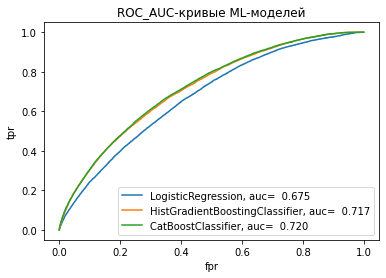



the best model is CatBoostClassifier with roc_auc = 0.7203567411478551


In [130]:
# Обучим модели и найдем roc_auc метрику на тестовой выборке
best_model_name,best_model,best_value = modeling_train_test(models, X, y)

Анализ GridSerach за разумное время (несколько часов) не выявил комбинации гиперпараметров ML-моделей, заметно улучшающих лучшую метрику. Поэтому для экономии вычислительного времени он тут не приводится.

In [131]:
# Найдем вклады переменных в предсказание модели (feature_importances)
if best_model_name == 'CatBoostClassifier':
    impotances = best_model.get_feature_importance()
else:
    impotances = best_model.feature_importances_

dict(zip(X.columns,impotances))

{'visit_number': 5.725308858558556,
 'utm_source': 12.424716945952117,
 'utm_medium': 6.458274607457942,
 'utm_campaign': 13.180710555085843,
 'utm_adcontent': 11.728330271849151,
 'device_brand': 4.960080882767376,
 'device_browser': 4.550134260856076,
 'geo_city': 16.340272650716738,
 'visit_dayofweek': 2.6018920744381764,
 'visit_day': 6.332211793438306,
 'visit_month': 8.066527555132737,
 'visit_hour': 5.767852297296772,
 'is_Russia': 0.5677309084943349,
 'is_mobile': 1.2959563379558843}

## 4.3. Весовые коэффициэнты для дискриминации классов

In [156]:
# Учитывая дисбаланс классов, необходимо задать порог срабатывания для вероятности отнесения к 1 или 0 
# Для этог созададим переменную class_weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
print ('class_weights: ', class_weights)
# Фактическая новая граница между классами
print ('class margin: ', 0.5/class_weights[1.0] )


class_weights:  {0.0: 0.5139009840152774, 1.0: 18.484338355129786}
class margin:  0.027049926829609224


In [160]:
# Найдем матрицу ошибок
y_pred = (best_model.predict_proba(X)[:, 1]*class_weights[1.0] >= 0.5)
conf = confusion_matrix(y, y_pred)
conf

array([[1143194,  666534],
       [  14071,   36243]], dtype=int64)

# 5. Выводы

In [69]:
print(f'Наиболее эффективной показала себя модель {best_model_name} c ROC_AUC= {best_value: 0.3f}')

Наиболее эффективной показала себя модель CatBoostClassifier c ROC_AUC=  0.720


# Спасибо за внимание!